In [1]:
#importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [2]:
#building the environment
class Environment:
    def __init__(self, M,N, holes, terminal_state): #initializing the environment states, holes, terminals and rewards
        self.states = set()
        self.shape = (M,N)
        self.holes = holes
        self.terminal_state = terminal_state
        
        for i in range(1,M+1):
            for j in range(1, N+1):
                if (i,j) not in holes:
                    self.states.add((i,j))
                    
        self.rewards = self.initialize_rewards()
        self.prob_agent_action = [0.8, 0.1, 0.05, 0.05]
    def initialize_rewards(self): #function to initialize the rewards for each state of the environment
        r = {}
        for state in self.states:
            if state == (6,3):
                r[state] = -15
            elif state == (6,6):
                r[state] = 15
            else:
                r[state] = 0
                
        return r
    
    def agent_move(self, s, a): #function to update the state of the agent given an action a and current state s
        x, y = s
        if a=='U':
            x = x-1
        elif a=='D':
            x = x + 1
        elif a=='R':
            y = y + 1
        elif a=='L':
            y = y - 1
            
        stay_same = self.check_corner_and_hole((x,y))

        if stay_same:
            return s

        return (x,y)

    def move_clockwise90(self, a): #function to return the action which is a 90 degree rotation to current action a
        if a=='U':
            return 'R'
        elif a=='R':
            return 'D'
        elif a=='D':
            return 'L'
        elif a=='L':
            return 'U'
        
    def move_anti_clockwise90(self, a): #function to return the action which is a 90 degree rotation to current action a
        if a=='U':
            return 'L'
        elif a=='L':
            return 'D'
        elif a=='D':
            return 'R'
        elif a=='R':
            return 'U'
    
    def check_corner_and_hole(self, s): 
        #function to check if the updates state goes out of the gridworld or goes into holes. 
        #If so, it returns a True value to address that the update should not take place and agent should remain in current state. 
        x1, y1 = s
        stay_same = False
        for hole in self.holes:
            if (x1,y1) == hole:
                stay_same = True

        if x1<1 or x1>6:
            stay_same = True
        if y1<1 or y1>6:
            stay_same = True
        
        return stay_same
    
    def get_new_state(self, s, a): 
        #this is the function to take the agent to an update state given the agent's choice of action and current state.
        #This encapsulates the dynamics of the environment and is not known to the Monte Carlo agent. The agent only
        #produces the current state s and his choice of action a, to which the environment returns his new state s1.
        x, y = s
        t = random.random()
        
        if t<=0.8: #agent's action succeeds
            x1,y1 = self.agent_move(s,a)
            return (x1,y1)
        
        elif 0.8<t<=0.9: #agent stays in same state
            return s
        
        elif 0.9<t<=0.95: #move in a 90 degree clockwise direction
            a1 = self.move_clockwise90(a)
            s1 = self.agent_move(s, a1)
            return s1
        else: #move in a -90 degree clockwise direction
            a1 = self.move_anti_clockwise90(a)
            s1 = self.agent_move(s, a1)
            
            return s1
            

In [3]:
gridworld = Environment(6,6, [(4,3),(5,3)], (6,6))


In [28]:
#building the Monte Carlo Agent
class MC_Agent:
    def __init__(self, gamma, env, first_visit = True, epsilon = 0.15):
        #initializing the parameters of the agent
        self.actions = ['L','R','U','D'] #possible actions
        self.gamma = gamma #discount parameter
        self.pi = self.initialize_policy(env)
        self.V = self.initialize_value_states(env)
        self.Q, self.returns, self.returns_pred = self.initialize_Qvalue_and_returns(env)
        self.epsilon = epsilon
        self.first_visit = first_visit
        
    def initialize_policy(self,env):
        #initializing the policy of the agent to be the policy of taking each action with probability 0.25
        pi = {}
        for s in env.states:
            pi[s] = {}
            for a in self.actions:
                pi[s][a] = 0.25
                
        return pi
    
    def reset(self,env):
        #function to reset the parameters learnt by the agent. The agent must reset his parameters in between trials.
        #That is, for trial 1 the agent runs M episodes learning the parameters. However, it must reset before trial 2. 
        for s in env.states:
            isTerminal = False
            if s == env.terminal_state:
                self.V[s] = 15
                isTerminal = True
            else:
                self.V[s] = random.random()
                self.returns_pred[s] = []

            for a in self.actions:
                self.pi[s][a] = 0.25
                self.returns[s][a] = []
                
                if isTerminal:
                    self.Q[s][a] = 15
                else:
                    self.Q[s][a] = random.random()
                
        
    def initialize_Qvalue_and_returns(self, env):
        #function to initialize the Q values and returns (both control and prediction) 
        Q = {}
        returns = {}
        returns_pred = {}
        self.visits = {}
        self.returns_pred = {}
        
        for s in env.states:
            Q[s] = {}
            returns[s] = {}
            self.visits[s] = 0
            isTerminal = False
            
            if s==env.terminal_state:
                isTerminal = True
            
            if not isTerminal:
                returns_pred[s] = []
                
            for a in self.actions:
                if isTerminal==True:
                    Q[s][a] = 15
                else:
                    Q[s][a] = random.random()
                    
                returns[s][a] = []
                
        return Q, returns, returns_pred
    
    def initialize_value_states(self, env):
        #function to initialize the value of the states
        v_s = {}
        for state in env.states:
            if state == env.terminal_state:
                v_s[state] = 15
            else:
                v_s[state] = random.random()
        return v_s
    
    def possible_actions(self, s):
        #function to return the possible actions in a given state
        actions = [a for a in self.pi[s]]
        return actions
    
    
    
    def sample_episode(self, env, start_state = (1,1)):
        #function to sample an episode with start state = (1,1) and terminal state = (6,6)
        s = start_state
        episode = []
        
        while s!=env.terminal_state:
            possible_actions = self.possible_actions(s)
            pi_a_s = [self.pi[s][a] for a in possible_actions]
            
            a = np.random.choice(possible_actions, p = pi_a_s)
            #self.visits[s][a] +=1
            s1 = env.get_new_state(s,a)
            r = env.rewards[s1]
            
            episode.append((s,a,r))
            
            s = s1
        
        episode.append(s)    
        return episode
    

    
    def find_first_visits(self,episode):
        #function to find the first visit of each state action pair (s,a) in the episode
        visits = {}
        i = 0
        for i in range(len(episode)):
            s,a,r = episode[i]
            if (s,a) not in visits:
                visits[(s,a)] = i
                
        return visits
    
    def compute_q_value(self, episode):
        #function to update the q(s,a) values for Monte Carlo on policy epsilon soft control algorithm
        G = 0
        terminal_state = episode.pop()
        
        T = len(episode)
        visits = self.find_first_visits(episode)
        
        for t in range(T-1, -1, -1):
            s,a,r = episode[t]
            G = (self.gamma*G) + r
            if self.first_visit == True:
                if visits[(s,a)]==t:
                    self.returns[s][a].append(G)
                    self.Q[s][a] = np.mean(self.returns[s][a])
            else:
                self.returns[s][a].append(G)
                self.Q[s][a] = np.mean(self.returns[s][a])
    
    def find_first_occurence_states(self,episode):
        #function to find first occurence of states in Monte Carlo Prediction algorithm
        end_state = episode.pop()
        n = len(episode)
        first_occurences = {}
        for i in range(n):
            s,a,r = episode[i]
            if s not in first_occurences:
                first_occurences[s] = i
        
        return first_occurences
    
    def MC_Prediction(self, env):
        #function for MC Prediction to sample an episode and update value of each state s in the episode
        
        '''episode_sampled = False
        episode = None
        while not episode_sampled:
            episode = self.sample_episode(env)
            if len(episode)<=100:
                episode_sampled = True'''
        
        episode = self.sample_episode(env)
        if self.first_visit:
            first_occurences_states = self.find_first_occurence_states(episode.copy())
        
        last_state = episode.pop()
        T = len(episode)
        G = 0
        for t in range(T-1, -1, -1):
            s,a,r = episode[t]
            G = (self.gamma*G) + r
            self.visits[s] +=1
            if self.first_visit == True:
                if first_occurences_states[s]==t:
                    self.returns_pred[s].append(G)
                    #self.V[s] = np.mean(self.returns_pred[s])
            else:
                self.returns_pred[s].append(G)
                #self.V[s] = np.mean(self.returns_pred[s])
                 
        for s,_,_ in episode:
            self.V[s] = np.mean(self.returns_pred[s])
            
    def MC_OnPolicy(self, env):
        #MC on Policy control algorithm function to sample an episode, update q(s,a) values and update policy 
        
        '''episode_sampled = False
        episode = None
        while episode_sampled == False:
            episode = self.sample_episode(env)
            if len(episode)<=100:
                episode_sampled = True'''
        
        episode = self.sample_episode(env)
                
        self.compute_q_value(episode.copy())
        end_state = episode.pop()
        
        for s_t,a_t,r in episode:
            a_star = self.find_a_star(s_t)
            actions_s = self.possible_actions(s_t)
            n = len(actions_s)
            for a in actions_s:
                if a==a_star:
                    self.pi[s_t][a] = (1-self.epsilon) + (self.epsilon/n)
                else:
                    self.pi[s_t][a] = self.epsilon/n
                    
        
                    
                    
        
    def run_episodes(self, env, episodes = 50):
        #MC On policy control algorithm for running the agent. It returns the MC Prediction values of state (1,1) across episodes
        values = []
        for episode_no in tqdm(range(episodes)):
            self.MC_OnPolicy(env)
            for i in range(50):
                self.MC_Prediction(env)
            values.append(np.mean(self.returns_pred[(1,1)]))
            
        return values
            
                    
                
                
            
    def find_a_star(self, s):
        #function to find the greedy action based on Q values
        a_star = None
        max_q_sa = -np.inf
        for a in self.Q[s]:
            if self.Q[s][a] > max_q_sa:
                a_star = a
                max_q_sa = self.Q[s][a]
                
        return a_star
            
    
    def find_optimal_move(self, s):
        #function to return the optimal move based on current policy
        optimal_moves = []
        max_p = 0
        for a in self.pi[s]:
            if self.pi[s][a] > max_p:
                optimal_moves = [a]
                max_p = self.pi[s][a]
            elif self.pi[s][a] == max_p:
                optimal_moves.append(a)
                
        return optimal_moves
    
            
    def plot_state_and_policy(self, env, plot_state_values = False, label = None):
        #function to display the state values and the policy values
        plt.figure(figsize = (20, 10))
        Grid_plot=plt.subplot()
        M,N = env.shape
        for i in range(M):
            for j in range(N):
                s = (i+1, j+1)
                if s==env.terminal_state:
                    if plot_state_values:
                        t = round(self.V[s], 3)
                        value = str(s) + "\n\n" + str(t) + "\n\n" + "TERMINAL"
                    else:
                        value = "TERMINAL"
                elif s not in env.holes:
                    value=str(s)
                    move = self.find_optimal_move(s)
                    if plot_state_values==False:
                        value = value + '\n\n' + ','.join(move)
                    else:
                        t = round(self.V[s],3)
                        value = value + '\n\n' + str(t)
                else:
                    value = "HOLE"
                
                
                
                Grid_plot.text(j+0.5,N-i-0.5,value,ha='center',va='center')
        
        Grid_plot.grid(color='k')
        Grid_plot.axis('scaled')
        Grid_plot.axis([0, M, 0, N])
        
        Grid_plot.set_yticklabels([])
        Grid_plot.set_xticklabels([])
        if label is not None:
            plt.savefig(label) 
                
            
        
            

In [5]:
def play_MC_prediction(agent, env = gridworld, trials = 100, episodes = 50):
    values_s11 = []

    for trial in tqdm(range(trials)):
        values = []
        for episode_no in range(episodes):
            agent.MC_Prediction(env)
            values.append(np.mean(agent.returns_pred[(1,1)]))
        
        if trial!= (trials-1):
            agent.reset(env)
        
        values_s11.append(values)
    
    return values_s11

In [6]:
agent = MC_Agent(0.9, gridworld, first_visit = True)
values_s11 = play_MC_prediction(agent,episodes = 50)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.15it/s]


In [11]:
def plot_value_s11(values_s11, label = None):
        avg_v = np.mean(values_s11, axis = 0)
        #print (avg_v[:20])
        ts = np.arange(1,(len(avg_v)+1))
        plt.plot(ts, avg_v)
        plt.xlabel("Episode number")
        plt.ylabel("Avg value of state (1,1)")
        plt.title("Monte Carlo Prediction of value of state (1,1) across episodes")
        if label:
            plt.savefig(label)
        plt.show()

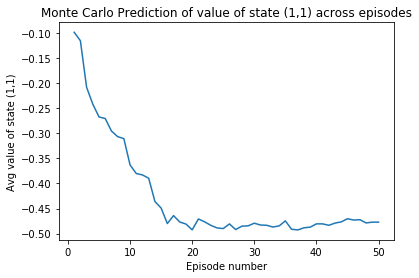

In [13]:
plot_value_s11(values_s11, label = 'plots/MC_First_visit_prediction.png')

In [10]:
np.mean(values_s11,axis = 0)[-1]

-0.4771769300935882

So, the Monte Carlo first visit Prediction algorithm after running for 50 episodes estimates the value of state(1,1) to be -0.477 for the policy of choosing each action uniformly with a probability of 0.25 which is very close to the optimal value found by the Policy Evaluation algorithm (-0.471). 

In [24]:
agent = MC_Agent(0.9, gridworld, first_visit = False)
values_s11 = play_MC_prediction(agent,episodes = 50)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.33it/s]


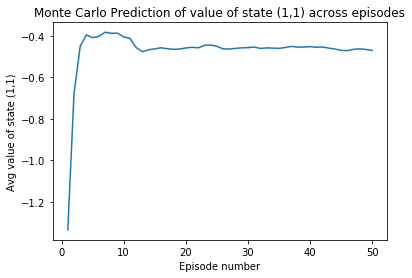

In [27]:
plot_value_s11(values_s11, label = 'plots/MC_every_visit_prediction.png')

In [26]:
np.mean(values_s11, axis = 0)[-1]

-0.4699803001771958

So, the Monte Carlo every visit Prediction algorithm after running for 50 episodes estimates the value of state(1,1) to be -0.4699 for the policy of choosing each action uniformly with a probability of 0.25 which is also very close to the optimal value found by the Policy Evaluation algorithm (-0.471). 

Thus we can say that both these algorithms (first visit and every visit) are successfully evaluating the value of state (1,1) for the policy of taking each action with equal probability (0.25).  

### Monte Carlo Control: On policy epsilon soft

For Monte Carlo control, I am using the On Policy epsilon soft algotithm with epsilon value of 0.15. 

#### First Visit

For first visit MC On policy control, I ran the agent for 100 episodes and it gave a near optimal policy where the agent would be able to reach the terminal state following the policy.

In [29]:
agent = MC_Agent(gamma = 0.9, env = gridworld, first_visit = True, epsilon = 0.15)
values_s11 = agent.run_episodes(gridworld, episodes = 100)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.63it/s]


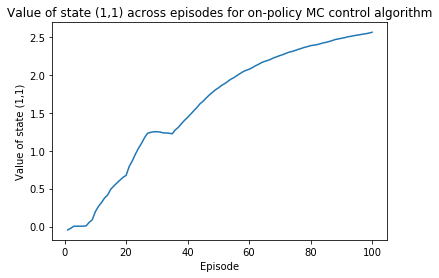

In [34]:
ts = np.arange(1, len(values_s11)+1)
plt.plot(ts,values_s11)
plt.xlabel("Episode")
plt.ylabel("Value of state (1,1)")
plt.title("Value of state (1,1) across episodes for on-policy MC control algorithm")
plt.savefig('plots/MC_control_first_visit_state_value')
plt.show()

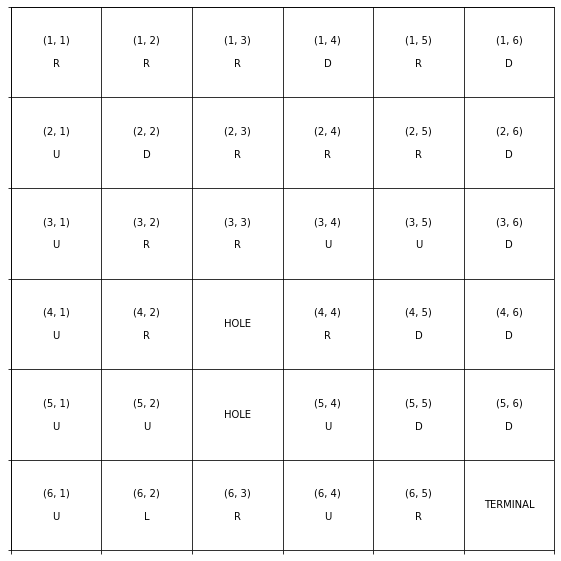

In [35]:
agent.plot_state_and_policy(gridworld,label = "plots/MC_control_first_visit_opt_policy.png")

#### Every Visit

For every visit MC On Policy Control algorithm, I ran the agent for 500 episodes, but the agent did not converge to even a near optimal policy as the agent may get stuck in the states (4,1), (6,1) and (6,2). 

In [40]:
agent = MC_Agent(gamma = 0.9, env = gridworld, first_visit = False, epsilon = 0.15)
values_s11 = agent.run_episodes(gridworld, episodes = 500)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [09:51<00:00,  1.18s/it]


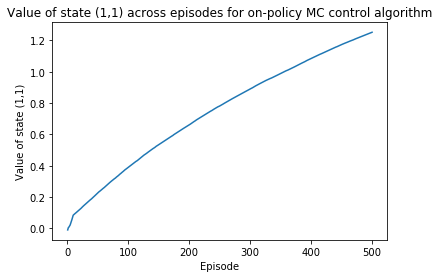

In [42]:
ts = np.arange(1, len(values_s11)+1)
plt.plot(ts,values_s11)
plt.xlabel("Episode")
plt.ylabel("Value of state (1,1)")
plt.title("Value of state (1,1) across episodes for on-policy MC control algorithm")
plt.savefig('plots/MC_control_every_visit_state_value')
plt.show()

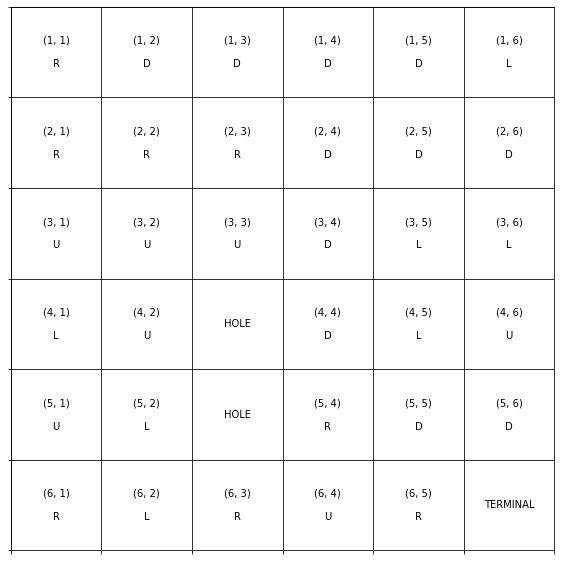

In [43]:
agent.plot_state_and_policy(gridworld, label = "plots/MC_control_every_visit")